In [3]:
# Set up imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import copy

# Defining Supporting functions

In [4]:
# Distance function
def distance(cities, cityorder):
    totaldistance = 0
    for i in range(len(cityorder)):
        x1,y1 = cities[cityorder[i]]
        x2,y2 = cities[cityorder[(i+1)%len(cityorder)]]
        totaldistance += ((x2-x1)**2 + (y2-y1)**2)**0.5
    return totaldistance

# Probability function
def P(dE):
    global T
    k = 1
    p = -1*(dE/k*T)
    return math.exp(p)

tsp_old is a function which uses the brute force algorithm to calculate the best path . It is extremely slow due to its exponential efficiency. This was written so that for small values of N (<10) , I can compare the results of Annealing with the actual shortest path.

In [5]:
# Functions for finding shortest path by brute force
def path_optimise(cities,path,remaining):
    if(len(remaining) == 1):
        #print(distance(cities,path+remaining),path+remaining)
        return distance(cities,path+remaining),path+remaining
    else:
        min_d = None
        for i in remaining:
            k = remaining[:]
            k.remove(i)
            m,p = path_optimise(cities,path+[i],k)# Recursive calls to all possibilities
            if(min_d == None):
                min_d = m
                min_p = p
            elif(m < min_d):
                min_d = m
                min_p = p
        return min_d,min_p
def tsp_old(cities):
    A = [0]
    x = path_optimise(cities,A,list(range(1,len(cities))))
    return x[0],x[1]

This tsp function follows the method of simulated annealing as taught in class . Simulated annealing technique is applied on each step wherein each step is a swap of 2 randomly selected elements in the current order of elements. There is one modification which has been made here , since simulated annealing has a lot of probability and randomness involved , it is better to take multiple iterations of simulated annealing and choose the best of these . I also vary the hyperparameters of T and decay rate as we go through this iterations. I have restricted myself to 5 iterations in this submission due to computational constraints , but ideally the number of iterations should be made to vary with N. 

In [29]:
# main function
def tsp(cities):
    global T,decay
    T1 = T
    decay1 = decay
    best ,best_d,improvement = once(cities,T1,decay1)
    improvement -= best_d
    print(best,best_d)
    for i in range(4):
        path_new , d_new , d_start = once(cities,T1,decay1)
        print(path_new,d_new)
        if(d_new < best_d):
            best = path_new
            best_d = d_new
            improvement = d_start-d_new
    # plotting the path
    plt.cla()
    xplot = [cities[i][0] for i in best]
    yplot = [cities[i][1] for i in best]
    xplot = np.append(xplot, xplot[0])
    yplot = np.append(yplot, yplot[0])
    plt.plot(xplot, yplot, 'o-')
    plt.show()
    improvement = (improvement)/(improvement+best_d)*100
    return best, best_d ,improvement
def once(cities,T,decay):
    N = len(cities)
    path = np.arange(N)
    np.random.shuffle(path)
    #print('initial random path:')
    f = distance(cities,path)
    c = 0
    path_best = path[:]
    while(True):
        a,b = np.random.randint(N),np.random.randint(N)
        path_new = copy.copy(path)
        for i in range(a,b+1):
            path_new[i] = path[b+a-i] 
        #path_new[a],path_new[b] = path_new[b],path_new[a]
        d1 = distance(cities,path_best)
        d2 = distance(cities,path_new)
        revert = 0
        # Annealing cases here
        if(d2 < d1):
            revert = 0
            path = copy.copy(path_new)
            path_best = copy.copy(path)
            #print(path_best,distance(cities,path_best))
        elif(P(d2-d1) > np.random.randint(100)/100):
            revert += 1
            path = path_new[:]
            T *= decay
            if(T < 5):
                break
        #exit condition if the branch is going off too far
        elif(distance(cities,path_new) > 2*distance(cities,path_best)):
            path = path_best[:]
            T = T/(decay**revert)
        c += 1
        if(c == 8000):
            break
    return path_best,distance(cities,path_best) , f

Code for comparing tsp_old and tsp

In [31]:
N = 40
x_cities = np.random.random((N,1))
y_cities = np.random.random((N,1))
cities = [(x_cities[i],y_cities[i]) for i in range(N)]
'''
#Test this with N <= 10
print('best path:')
print(tsp_old(cities))
print('result from sim_anneal')
T = 2500
decay = 0.999
print(tsp(cities))
'''

"\n#Test this with N <= 10\nprint('best path:')\nprint(tsp_old(cities))\nprint('result from sim_anneal')\nT = 2500\ndecay = 0.999\nprint(tsp(cities))\n"

From this we can see the advantage of taking 5 iterations of sim_anneal. Although each of the above iterations got us a close approximation , taking the best of 5 iterations significantly increases our chance of reaching the absolute best path.

Running the code

[30 20 21 19 17 11  3 22 10 38 34 14 15 23 39 28  9  0 37 29  5 12  4 32
  7  2 35  8 27 31  6 36 16 25  1 26 18 24 13 33] 5.964200289663436
[25 39 28  9  0 37 29  5 12  4 32  7  2 35  8 27 31 13 33 24 18 26 30 20
 19 17 21  6 36 16  1 11  3 34 38 10 22 23 15 14] 5.593504264832149
[ 0 37 29  5 12  4 32  7  2 35  8 27 13 33 24 18 26 30 20 19 21 17 34 38
 10 22  3 11 14 23 15  1  6 31 36 16 25 39 28  9] 5.830433644389996
[30 20 19 17 21 26 18 31  6 36  1 11  3 34 38 10 22 14 15 23 28  9  0 29
  5 12 37 39 25 16  4 32  7  2 35  8 27 13 24 33] 6.400875952335382
[29  5 12  4 36 32  7  2 35  8 27 13 33 24 18 30 20 19 21 26 31  6  1 16
 25 11 17 38 10 22 34  3 14 15 23 39 28 37  9  0] 6.253038305525535


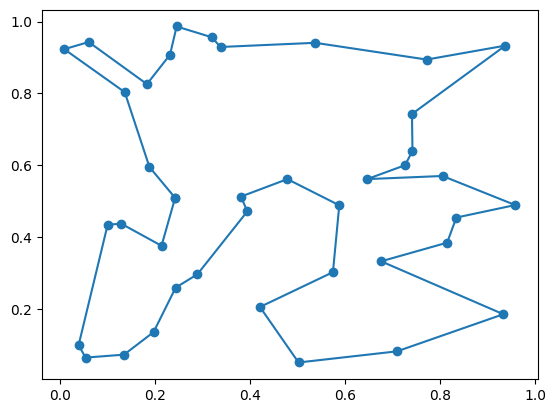

[25 39 28  9  0 37 29  5 12  4 32  7  2 35  8 27 31 13 33 24 18 26 30 20
 19 17 21  6 36 16  1 11  3 34 38 10 22 23 15 14] 5.593504264832149


In [44]:
T = 10000
decay = 0.999
finalorder = tsp(cities)
print(finalorder[0],distance(cities,finalorder[0]))

Calculating results for the given test case

[ 9  0 37 29  5 12  4 32  7  2 35  8 27 13 33 24 18 30 20 26 21 17 19 38
 10 22 34  3 11 14 23 15  1  6 31 36 16 25 39 28] 5.759285119304606
[10 22  3 11 14 23 15 25  1 16 39 28 37  9  0 29  5 12  4 32  2  7 35  8
 27 31 36 21 26  6 13 33 24 18 30 20 19 17 34 38] 5.814330170461174
[16 39 37 28  9  0 29  5 12  4 32  7  2 35  8 27 31 36  6 21 26 18 24 13
 33 30 20 19 17 11 34 38 10 22  3 14 23 15 25  1] 5.669262789560815
[11  3 34 38 10 22 23 15 39 28  9  0  5 12  4 29 37 25 14  1 16 36  6 26
 31 27 32  7  2 35  8 13 33 24 18 30 20 19 21 17] 6.26732943572296
[ 7  2 33 30 18 24 13  8 27 31  6 26 21 20 19 17 34 38 10 22  3 11 14 23
 15  1 36 16 25 39 28  9  0 37 29  5 12  4 32 35] 5.8963522320074135


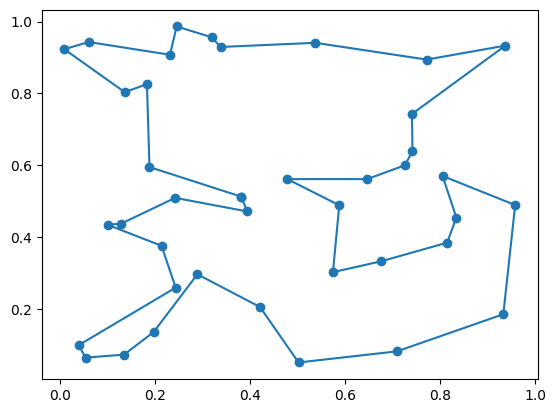

best_path: [16 39 37 28  9  0 29  5 12  4 32  7  2 35  8 27 31 36  6 21 26 18 24 13
 33 30 20 19 17 11 34 38 10 22  3 14 23 15 25  1]
best_distance: 5.669262789560815
improvement: 72.42162918323068


In [45]:
f = open('tsp40.txt','r')
k = 1
cities = []
for i in f.readlines()[1:]:
    x,y = i.split(' ')
    cities.append([float(x),float(y)])

best_path , best_distance , improvement = tsp(cities)
print('best_path:' , best_path)
print('best_distance:',best_distance)
print('improvement:',improvement)

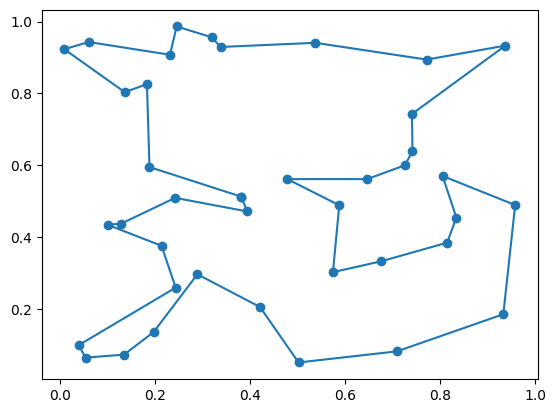

In [46]:
plt.cla()
xplot = [cities[i][0] for i in best_path]
yplot = [cities[i][1] for i in best_path]
xplot = np.append(xplot, xplot[0])
yplot = np.append(yplot, yplot[0])
plt.plot(xplot, yplot, 'o-')
plt.savefig('tsp1')